# Librerías

In [4]:
# Sistema y utilidades
import os
import glob
import math
import random
import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils

# Manejo de imágenes
from PIL import Image

# Visualización
import matplotlib.pyplot as plt

# Control de progreso (opcional pero útil)
from tqdm import tqdm

In [5]:
# Semilla aleatoria
seed = 42

# Fijamos la semilla para Pytorch y Numpy
torch.manual_seed(seed)
np.random.seed(seed)

"""
Dispositivo: usamos GPU si está disponible
"acelerar" la velocidad de entrenamiento de las redes neuronales al utilizar la GPU del computador (o cambiando el Runtime Type en Colab a uno con GPU)
Si presenta errores extraños ligados a "CUDA", settea esta variable como "cpu".
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hacemos que el modelo solo vea imágenes de frutillas a color


/content/ncd:
NCD

/content/ncd/NCD:
ColorfulOriginal  Gray

/content/ncd/NCD/ColorfulOriginal:
Apple	  CapsicumGreen  Corn	     Orange  Pomegranate
Banana	  Carrot	 Cucumber    Peach   Potato
Brinjal   Cherry	 LadyFinger  Pear    Strawberry
Broccoli  ChilliGreen	 Lemon	     Plum    Tomato

/content/ncd/NCD/ColorfulOriginal/Apple:
Apple10.jpg  Apple16.jpg  Apple22.jpg  Apple27.jpg  Apple35.jpg  Apple4.jpg
Apple11.jpg  Apple17.jpg  Apple23.jpg  Apple30.jpg  Apple36.jpg  Apple5.jpg
Apple12.jpg  Apple1.jpg   Apple24.jpg  Apple32.jpg  Apple37.jpg  Apple6.jpg
Apple13.jpg  Apple20.jpg  Apple25.jpg  Apple33.jpg  Apple38.jpg  Apple7.jpg
Apple14.jpg  Apple21.jpg  Apple26.jpg  Apple34.jpg  Apple3.jpg	 Apple9.jpg

/content/ncd/NCD/ColorfulOriginal/Banana:
banana10.jpg  banana19.jpg  banana27.jpg  banana35.jpg	banana44.jpg
banana11.jpg  banana1.jpg   banana28.jpg  banana36.jpg	banana45.jpg
banana12.jpg  banana20.jpg  banana29.jpg  banana37.jpg	banana4.jpg
banana13.jpg  banana21.jpg  banana2.jpg   

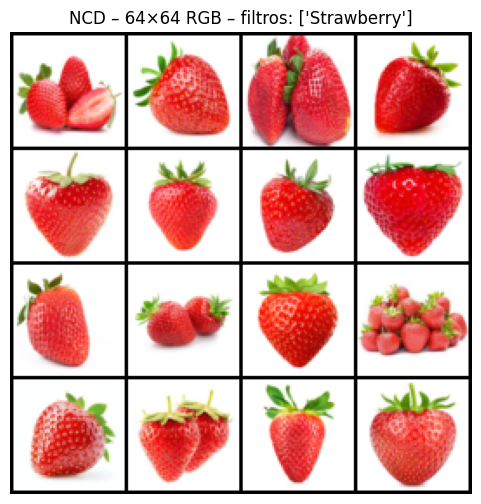

In [13]:
# Dataset: Natural Color Dataset (NCD) desde ZIP subido manualmente
# Este bloque carga el ZIP, filtra imágenes por clase (keywords) y arma el DataLoader.

"""
Seleccionar clase(s) a entrenar:
Ejemplos de keywords disponibles en el Natural Color Dataset (NCD):
["Strawberry"], ["Banana"], ["Apple"], ["Pomegranate"], ["Eggplant"], etc.

O combinar: ["Strawberry", "Pomegranate"]
"""
CLASS_KEYWORDS = ["Strawberry"]   # modificar para cambiar la clase a entrenar


# Descomprimir dataset
zip_path = "/content/archive.zip"      # ajustar si tiene otro nombre
!mkdir -p /content/ncd
!unzip -oq "$zip_path" -d "/content/ncd"
!ls -R /content/ncd                    # inspeccionar estructura resultante para encontrar la raíz real

# Dataset personalizado con filtro por clase
class NCDDataset(Dataset):
    def __init__(self, root_dir, img_size=64, class_keywords=None):
        """
        root_dir: carpeta base del dataset
        img_size: tamaño al que se reescalar cada imagen
        class_keywords: lista de strings que deben aparecer en la ruta (case-insensitive)
        """
        self.root_dir = root_dir

        # Todas las imágenes posibles
        all_paths = sorted(
            glob.glob(os.path.join(root_dir, "**", "*.jpg"), recursive=True)
        ) + sorted(
            glob.glob(os.path.join(root_dir, "**", "*.png"), recursive=True)
        )

        # Filtrar por clase
        if class_keywords is not None:
            kws = [k.lower() for k in class_keywords]
            filtered_paths = [
                p for p in all_paths
                if any(k in p.lower() for k in kws)
            ]
        else:
            filtered_paths = all_paths

        # Filtrar SOLO imágenes a color (RGB)
        rgb_paths = []
        for p in filtered_paths:
            try:
                img = Image.open(p)
                if img.mode == "RGB":
                    rgb_paths.append(p)
            except:
                pass  # ante cualquier error, descarta imágenes corruptas

        self.img_paths = rgb_paths

        assert len(self.img_paths) > 0, \
            f"No se encontraron imágenes RGB en {root_dir} con filtros {class_keywords}"

        # Transformaciones
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                (0.5, 0.5, 0.5),
                (0.5, 0.5, 0.5)
            )
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")  # aseguramos salida RGB
        img = self.transform(img)
        return img, 0

# Ajustar si el zip genera una carpeta extra (ej: /content/ncd/NCD/)
RAIZ_NCD = "/content/ncd"

img_size = 64   # subir a 128 si la GPU aguanta
batch_size = 32

dataset = NCDDataset(
    RAIZ_NCD,
    img_size=img_size,
    class_keywords=CLASS_KEYWORDS
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print("Total de imágenes NCD (tras filtro):", len(dataset))

# Visualizar 16 ejemplos
batch = next(iter(dataloader))[0][:16]
batch_vis = batch * 0.5 + 0.5  # [-1,1] → [0,1]

grid = vutils.make_grid(batch_vis, nrow=4)
plt.figure(figsize=(6,6))
plt.axis("off")
plt.imshow(grid.permute(1,2,0).cpu())
plt.title(f"NCD – 64×64 RGB – filtros: {CLASS_KEYWORDS}")
plt.show()


# Formulas, parametros y erramientas para los tensores

In [14]:
# Hiperparámetros de difusión (DDPM) del paper

T = 1000                                                                        # pasos de difusión (1000 si hay paciencia)
beta_start, beta_end = 1e-4, 2e-2
betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float32).to(device) # cuanto ruido nuevo se agrega en cada paso. crece linealmente

alphas = 1.0 - betas                                                 # cuanto se "conserva” de la señal previa en cada paso // fracción de señal que sobrevive
alphas_cumprod = torch.cumprod(alphas, dim=0)                        # pitatoria de los alphas hasta cad tiempo (tensor tambien) // cuánta señal original queda después de t pasos
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)   # Ajuste para casos borde // agrega algunos 1.0 al tensor en los b0rdes poder operar

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)                  # raiz del tensor alpha acumulado
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)  # raiz del tensor beta acumulado
sqrt_recip_alphas = torch.sqrt(1.0/alphas)                        # raiz del inverso de alpha acumulado

posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)   # \tilde{β}_t, varianza de 𝑞(𝑥_{𝑡−1}∣𝑥_𝑡,𝑥_0); para muestrear en el reverse (añadir el ruído correcto)

def extract(a, t, x_shape):
    """
    Extrae a[t] y lo da forma (B,1,1,1) para broadcast.
    t: (B,) int64
    """
    out = a.gather(-1, t).float()
    return out.view(-1, 1, 1, 1).expand(x_shape)

def q_sample(x_start, t, noise=None):
    """
    x_t = sqrt(alphacum[t])*x0 + sqrt(1 - alphacum[t])*ε , ε∼𝑁(0,𝐼) (noise)
    para generar “imagen con ruido de nivel t” sin simular paso a paso
    """
    if noise is None:
        noise = torch.randn_like(x_start)
    return extract(sqrt_alphas_cumprod, t, x_start.shape) * x_start + \
           extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise

# Red ("mini")

En los modelos anteriores trabajábamos con MNIST, es decir, imágenes **28×28 en escala de grises** de un único dígito. La red UNet correspondiente era más pequeña (menos canales y una sola entrada en blanco y negro).

En esta sección adaptamos la arquitectura al caso del **Natural Color Dataset (NCD)**:

- La red ahora recibe **imágenes RGB** (`img_ch = 3`) reescaladas a 64×64 (o 128×128 según la configuración del dataset).
- Aumentamos el ancho de la red (`base_ch = 64`) para darle mayor capacidad de representación, ya que las frutas tienen más textura, color y detalle que un dígito de MNIST.
- Mantenemos la misma idea central de los modelos anteriores: una **UNet con skip-connections** que predice el ruido $ \varepsilon_\theta(x_t, t)$, solo que ahora la arquitectura está dimensionada para imágenes a color de mayor resolución.
- La información del paso temporal \( t \) se sigue incorporando mediante un **embedding sinusoidal + MLP**, que se inyecta en cada bloque residual para que la red “sepa” en qué nivel de ruido está trabajando.

In [15]:
# Modelo: UNet mini para imágenes RGB (64×64 o 128×128 según config)

class SinusoidalPosEmb(nn.Module):
    """
    Embedding sinusoidal usado en DDPM: convierte un tiempo t en un vector
    de dimensión 'dim'. Es equivalente al positional encoding del Transformer.
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        # t: (B,) con enteros en [0, T-1]
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, dtype=torch.float32, device=device) / half)
        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return emb  # (B, dim)

class TimeEmbedding(nn.Module):
    """
    Proyecta el embedding sinusoidal a una representación más rica
    que luego será inyectada en cada ResBlock del UNet.
    """
    def __init__(self, dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim)
        )
    def forward(self, x):
        return self.mlp(x)

class ResBlock(nn.Module):
    """
    Bloque residual con normalización por grupos y modulación dependiente del tiempo.
    Permite que la UNet “sepa” en qué paso t del proceso de difusión se encuentra.
    """
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.act1  = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act2  = nn.SiLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        # Proyección del embedding temporal al número de canales del bloque
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_dim, out_ch))
        # Conexión residual adaptada si cambia el número de canales
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        # Primer paso conv → norm → activación
        h = self.conv1(self.act1(self.norm1(x)))
        # Inyectar información temporal (broadcast sobre H×W)
        t = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + t
        # Segundo paso conv → norm → activación
        h = self.conv2(self.act2(self.norm2(h)))
        return h + self.res_conv(x)   # salida residual

class UNetMini(nn.Module):
    """
    UNet simplificada para DDPM. Funciona con imágenes RGB del NCD
    reescaladas a 64×64 o 128×128 según img_size. Predice el ruido ε.
    """
    def __init__(self, img_ch=1, base_ch=32, time_dim=128):
        """
        img_ch: número de canales (3 para RGB)
        base_ch: canal base (64 recomendado para imágenes de fruta; subir para más calidad)
        time_dim: dimensión del embedding temporal
        """
        super().__init__()

        # Embedding temporal completo: sinusoidal + MLP
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            TimeEmbedding(time_dim, time_dim)
        )
        # Encoder
        self.in_conv = nn.Conv2d(img_ch, base_ch, 3, padding=1)
        self.rb1 = ResBlock(base_ch,   base_ch,   time_dim)
        self.down1 = nn.Conv2d(base_ch, base_ch*2, 4, stride=2, padding=1)    # reduce H,W a la mitad
        self.rb2 = ResBlock(base_ch*2, base_ch*2, time_dim)
        self.down2 = nn.Conv2d(base_ch*2, base_ch*4, 4, stride=2, padding=1)  # vuelve a reducir H,W a la mitad
        self.rb3 = ResBlock(base_ch*4, base_ch*4, time_dim)  # 7x7

        # Bottleneck
        self.mid1 = ResBlock(base_ch*4, base_ch*4, time_dim)

        # Decoder
        self.up1 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 4, stride=2, padding=1)
        self.rb4 = ResBlock(base_ch*4, base_ch*2, time_dim)
        self.up2 = nn.ConvTranspose2d(base_ch*2, base_ch, 4, stride=2, padding=1)
        self.rb5 = ResBlock(base_ch*2, base_ch, time_dim)
        # Conv final: proyecta al mismo número de canales de la imagen (predicción de ε)
        self.out_conv = nn.Conv2d(base_ch, img_ch, 1)

    def forward(self, x, t):
        t_emb = self.time_emb(t)  # (B, time_dim)

        # Encoder
        x0 = self.in_conv(x)
        x1 = self.rb1(x0, t_emb)
        x2 = self.down1(x1)
        x3 = self.rb2(x2, t_emb)
        x4 = self.down2(x3)
        x5 = self.rb3(x4, t_emb)

        # Bottleneck
        m  = self.mid1(x5, t_emb)

        # Decoder
        u1 = self.up1(m)
        u1 = torch.cat([u1, x3], dim=1)
        u1 = self.rb4(u1, t_emb)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, x1], dim=1)
        u2 = self.rb5(u2, t_emb)

        out = self.out_conv(u2)
        return out  # predicción del ruido ε

# Entrenamiento

Entrenamiento: Minimizar $𝔼_{t,x_0,ε}$[ $||ε-ε_{θ}(x_{t}, t)||^2$ ]

$𝔼_{t,x_0,ε}$[ $||ε-ε_{θ}(\sqrt{\hat{α}}·x_0+\sqrt{1-\hat{α}}·ε, t)||^2$ ]



Intuitivamente: cada parámetro de la red (los pesos de sus neuronas) es una perilla que se puede girar.\
El objetivo es girarlas en la dirección que baja la pérdida $𝔼_{t,x_0,ε}$

In [17]:
# Entrenamiento

"""
MODIFICAR:
lr = 2e-4 -> aumentar para mayor precision (avanza mas lento el decenso de gradiente, menos perdida de MSE por tanda)
epoch = 100 -> aumentar para mayor precision (demora mas el entrenamiento, mas tandas)
"""

model = UNetMini(img_ch=3, base_ch=32, time_dim=128).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4) # optimizamos con descenso de gradiente ajustado para no sobre dimensionar errores y AdamW de algoritmo

loss_step_hist = []    # loss por iteración
loss_epoch_hist = []   # promedio por época

epochs = 12000      # "tandas" de entrenamiento // subir para mejor calidad // [15,50]epochs ==> [30,90]minutos
log_every = 100  # frecuencia de logging
global_step = 0
model.train()    # inicia el entrenamiento

for epoch in range(1, epochs+1):
    running = 0.0
    num_logged = 0
    for i, (x, _) in enumerate(dataloader):
        x = x.to(device)                                     # ya está en [-1,1] por la Normalization
        b = x.size(0)                                        # tamaño del Batch
        t = torch.randint(0, T, (b,), device=device).long()  # elige un t distinto unif para cada muestra, así el denoiser  entrena en todos los niveles
        noise = torch.randn_like(x)                          # ε∼𝑁(0,𝐼) de igual dimension q x
        x_noisy = q_sample(x, t, noise)                      # genera x_t

        pred_noise = model(x_noisy, t)        # prediccion del ruido ê
        loss = F.mse_loss(pred_noise, noise)  # Pérdida MSE entre ruido predicho y real (ε-ê)

        optimizer.zero_grad()  # Pone los gradientes acumulados en cero antes del siguiente paso
        loss.backward()        # Calcula hacia atrás qué debe ajustar // calcula los gradientes de la pérdida con respecto a todos los parámetros del modelo
        optimizer.step()       # actualizar pesos (parámetros del modelo) // Usa los gradientes para actualizar los pesos (con AdamW)

        # logging
        loss_val = loss.item()
        loss_step_hist.append(loss_val)
        running += loss_val  # Acumula running para imprimir promedios cada log_every iteraciones
        num_logged += 1
        global_step += 1
        if (i+1) % log_every == 0:
            print(f"Epoch {epoch} | step {i+1}/{len(dataloader)} | loss {running/log_every:.4f}")
            running = 0.0
            num_logged = 0

    # promedio por época
    start = len(loss_step_hist) - len(dataloader)
    loss_epoch = sum(loss_step_hist[start:]) / len(dataloader)
    loss_epoch_hist.append(loss_epoch)

# Guardar pesos
os.makedirs("ckpts", exist_ok=True)
torch.save(model.state_dict(), "ckpts/ddpm_ncd_strawberry_unetmini.pt")
print("Modelo guardado en ckpts/ddpm_ncd_strawberry_unetmini.pt")

Modelo guardado en ckpts/ddpm_ncd_strawberry_unetmini.pt


# Denosising

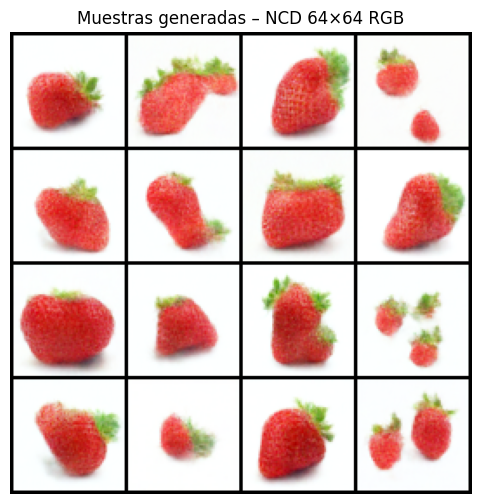

In [72]:
# Sampling: reconstrucción iterativa desde ruido puro (proceso inverso de DDPM)

@torch.no_grad()
def p_sample(model, x, t):
    # Extrae los coeficientes correspondientes al paso t para cada imagen del batch
    b = x.shape[0]
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    """
    predecimos el ruido:
    Estima x_{t-1} aplicando la fórmula del proceso inverso (media del posterior)
    Usa el ruido predicho por la red para "deshacer" parcialmente el difuminado
    """
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

    # En t = 0 ya no se agrega ruido, la muestra final es determinista
    if (t == 0).all():
        return model_mean
    else:
        # Varianza del posterior q(x_{t-1} | x_t, x_0)
        posterior_var_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_var_t) * noise

@torch.no_grad()
def p_sample_loop(model, shape, n_steps=T):
    # Comienza desde ruido gaussiano
    img = torch.randn(shape, device=device)
    model.eval()
    # Recorre t = T-1, ..., 0 aplicando el paso inverso en cada iteración
    for i in reversed(range(0, n_steps)):
        t = torch.full((shape[0],), i, device=device, dtype=torch.long)
        img = p_sample(model, img, t)
    return img

@torch.no_grad()
def sample_and_show(model, n=16):
    # Genera n imágenes desde ruido y las muestra en una cuadrilla (grilla)
    samples = p_sample_loop(model, (n, 3, img_size, img_size))
    grid = vutils.make_grid(samples, nrow=4, normalize=True, value_range=(-1,1))
    plt.figure(figsize=(6,6))
    plt.axis("off")
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.title("Muestras generadas – NCD 64×64 RGB")
    plt.show()

sample_and_show(model, n=16)

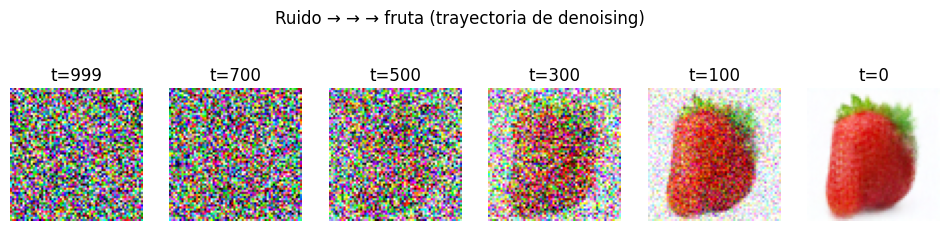

In [73]:
# Visualizar trayectoria de denoising para 1 imagen
@torch.no_grad()
def denoise_trajectory(model, steps_to_show=(299, 200, 120, 60, 20, 0)):
    img = torch.randn((1, 3, img_size, img_size), device=device)  # 3 canales
    imgs = {}
    model.eval()
    for i in reversed(range(0, T)):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = p_sample(model, img, t)
        if i in steps_to_show:
            imgs[i] = img.detach().clone().cpu()
    return imgs

steps = (T-1, int(T*0.7), int(T*0.5), int(T*0.3), int(T*0.1), 0)
traj = denoise_trajectory(model, steps_to_show=steps)

fig, axs = plt.subplots(1, len(steps), figsize=(12,3))
for j, s in enumerate(steps):
    img_rgb = traj[s][0].permute(1, 2, 0) * 0.5 + 0.5
    axs[j].imshow(img_rgb)
    axs[j].axis('off')
    axs[j].set_title(f"t={s}")
plt.suptitle("Ruido → → → fruta (trayectoria de denoising)")
plt.show()


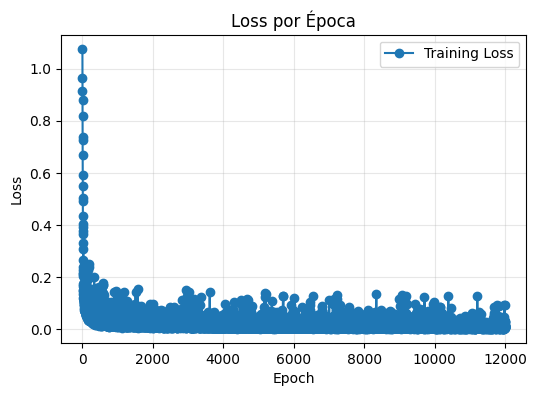

In [74]:
# Visualizar funcion de perdida por epoch
plt.figure(figsize=(6,4))
plt.plot(range(1, len(loss_epoch_hist)+1), loss_epoch_hist, label="Training Loss", marker='o')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss por Época")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

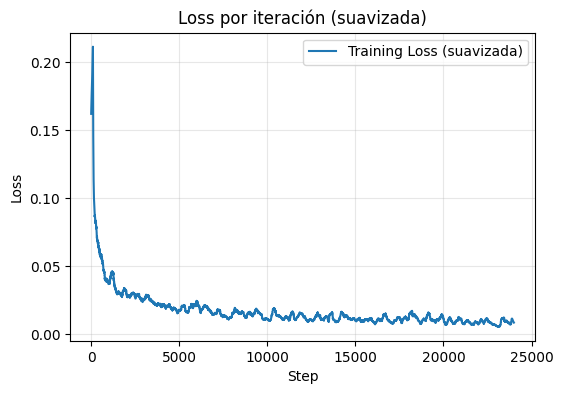

In [75]:
# Mas suave
def smooth(y, k=5):
    k = max(1, k)
    filt = np.ones(k)/k
    return np.convolve(y, filt, mode='same')
plt.figure(figsize=(6,4))
plt.plot(smooth(loss_step_hist, k=200), label="Training Loss (suavizada)")
plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Loss por iteración (suavizada)")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()